In [1]:
!pip install simpletransformers # for transformers wrapper for DL
!pip install ktrain # for ktrain wrapper for DL
!pip install nlpaug # for data augmantation
!pip install tqdm
!pip install tashaphyne # for stemming arabic words

     |████████████████████████████████| 248 kB 806 kB/s            
     |████████████████████████████████| 43 kB 1.7 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 9.9 MB 9.7 MB/s            
     |████████████████████████████████| 312 kB 59.4 MB/s            
     |████████████████████████████████| 212 kB 64.3 MB/s            
     |████████████████████████████████| 4.3 MB 59.0 MB/s            
     |████████████████████████████████| 76 kB 5.1 MB/s             
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=0aa07c4d4e2192015ca2f8b4568b69efb1f7844837f73fa22a64a050c6ca2869
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
     |████████████████████████████████| 25.3 MB 892 kB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 22.3 MB 47.5 MB/s            
     |████████

In [2]:
import numpy as np
import pandas as pd

import json, sys, regex, os
import torch
import torchvision
import random
random.seed(2022)

from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import requests
import re 

import os
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, TfidfTransformer

from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import pickle



from tqdm import tqdm


import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter




import ktrain
from ktrain import text

from sklearn.utils import shuffle
from transformers import TFRobertaModel, RobertaConfig, RobertaTokenizerFast

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf
from nlpaug.util import Action

from tashaphyne.stemming import ArabicLightStemmer

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 
%config InlineBackend.figure_format = 'retina'

# Importing data from my Google Drive.

In [3]:
data = pd.read_csv('../input/arabic-dialects/Ara_dialect.csv', lineterminator='\n')
data.head()

,id,tweets,dialect
0,1175358310087892992,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .,IQ
1,1175416117793349632,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...,IQ
2,1175450108898565888,@KanaanRema مبين من كلامه خليجي,IQ
3,1175471073770573824,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐,IQ
4,1175496913145217024,@hmo2406 وين هل الغيبه اخ محمد 🌸🌺,IQ


In [4]:
data.shape

(458197, 3)

## EDA

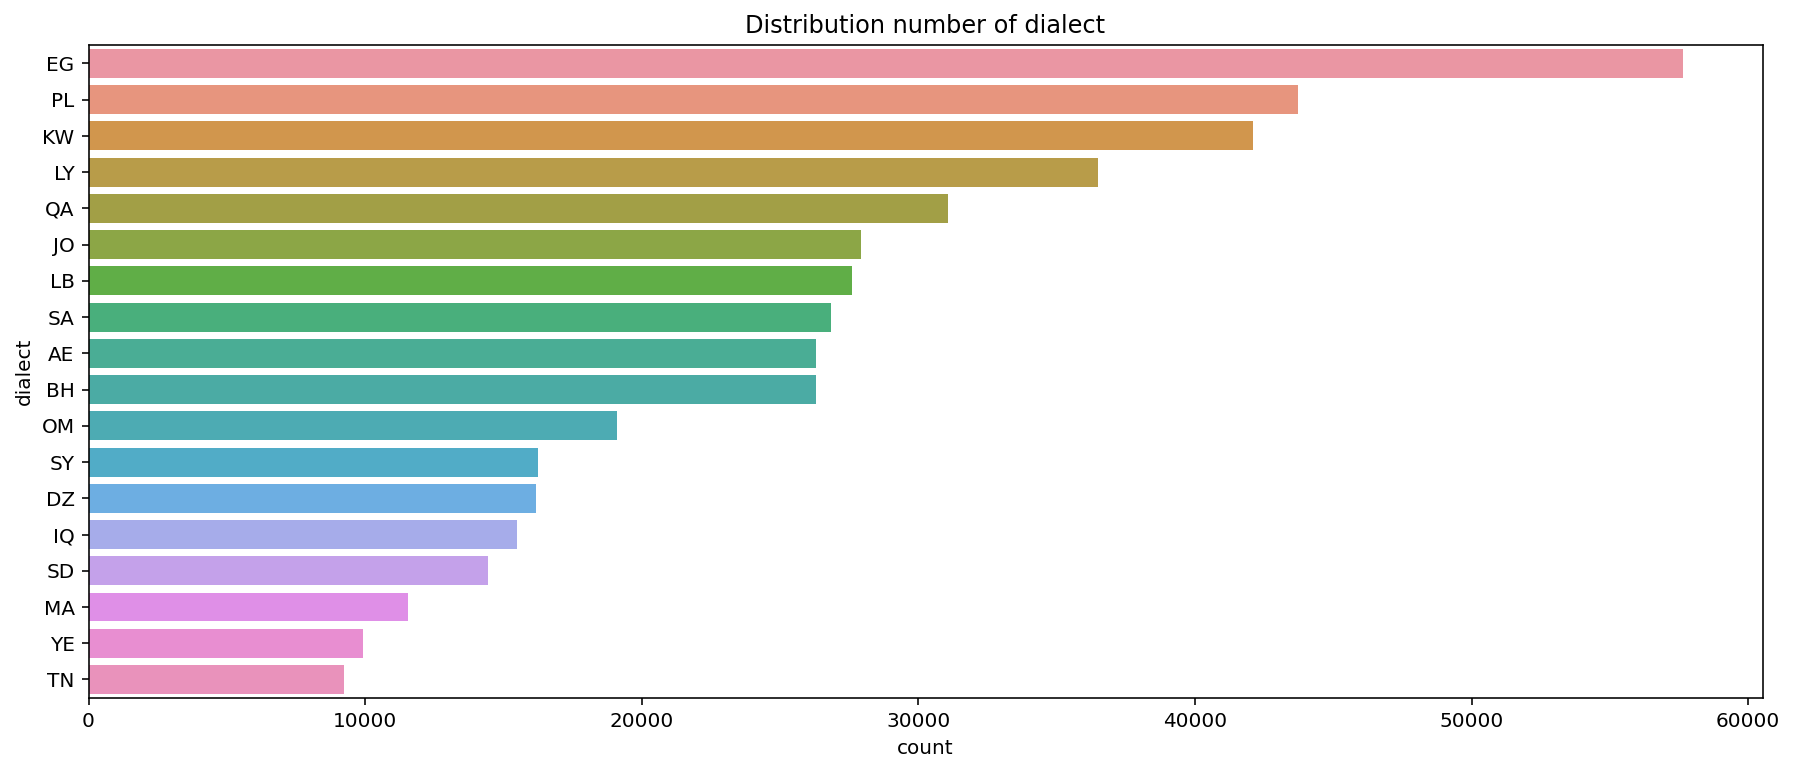

In [5]:
plt.figure(figsize=(15, 6))

sns.countplot(data = data, y= 'dialect',
             order = data['dialect'].value_counts().index)

plt.title('Distribution number of dialect')
plt.show();

In [6]:
pd.DataFrame(data.dialect.value_counts()).T

,EG,PL,KW,LY,QA,JO,LB,SA,AE,BH,OM,SY,DZ,IQ,SD,MA,YE,TN
dialect,57636,43742,42109,36499,31069,27921,27617,26832,26296,26292,19116,16242,16183,15497,14434,11539,9927,9246


**We sow `Egypt` have most number of tweets =D**

In [7]:
# number of dialects in data and all dialects

list_of_unique_dialect = list(set(data.dialect))
print(f'There are {len(data.dialect.value_counts())} of dialect kind')
print(f'the dialects are: \n{list_of_unique_dialect}')

There are 18 of dialect kind
the dialects are: 
['LB', 'YE', 'SD', 'SY', 'AE', 'QA', 'TN', 'SA', 'IQ', 'BH', 'JO', 'KW', 'OM', 'MA', 'EG', 'DZ', 'PL', 'LY']


**Sample of data for each dialect**
As we sow here, we need to doing some text cleaing to make machine understand the text, So we will meke:
* Removing emojis.
* Removing links.
* Removing mentions like @user.
* Removing hattage # .
* Removing puncituations.
* Removing duplicated characters.
* Removing new line "\n".
* Removing diacritization.
* Removing stop words.
* Just keep Arabic language.
<!-- * stemming for words. -->



In [8]:
print(data['tweets'][data['dialect'] == 'EG'][244697])
print('-'*50)

print(data['tweets'][data['dialect'] == 'PL'][83068])
print('-'*50)

print(data['tweets'][data['dialect'] == 'KW'][372056])
print('-'*50)

print(data['tweets'][data['dialect'] == 'LY'][15498])
print('-'*50)

print(data['tweets'][data['dialect'] == 'QA'][52000])
print('-'*50)

print(data['tweets'][data['dialect'] == 'JO'][180213])
print('-'*50)

print(data['tweets'][data['dialect'] == 'LB'][329947])
print('-'*50)

print(data['tweets'][data['dialect'] == 'SA'][218582])
print('-'*50)

print(data['tweets'][data['dialect'] == 'AE'][431900])
print('-'*50)


print(data['tweets'][data['dialect'] == 'BH'][458192])
print('-'*50)


print(data['tweets'][data['dialect'] == 'OM'][391170])
print('-'*50)


print(data['tweets'][data['dialect'] == 'SY'][126808])
print('-'*50)


print(data['tweets'][data['dialect'] == 'DZ'][244696])
print('-'*50)


print(data['tweets'][data['dialect'] == 'IQ'][1])
print('-'*50)


print(data['tweets'][data['dialect'] == 'SD'][405606])
print('-'*50)


print(data['tweets'][data['dialect'] == 'MA'][191750])
print('-'*50)


print(data['tweets'][data['dialect'] == 'YE'][228513])
print('-'*50)


print(data['tweets'][data['dialect'] == 'TN'][143049])
print('-'*50)

الاقيش معاك 25 الف يا عم نجيب قرض حسن ابدا بيهم حلمي وهسدهم على 25 شهر ولو عاوز تشاركني هسدهم بارضو وتبقى شريك بالربع ؟
@NaguibSawiris
--------------------------------------------------
مين الي شاغل بالك سميرا يا صغيرة.flv https://t.co/2eLq1J820n عبر @YouTube
--------------------------------------------------
@amer_alkubaisi @moonnor27 شسالفه كلهم يحمدون الله حتى الكلب والخنزير ..صج خبل
--------------------------------------------------
@AlmFaisal 😂😂 الليبيين متقلبين!!!
بس بالنسبة ليا انا ميليشياوي زمان وتوة
--------------------------------------------------
@1397Hma @almayassahamad @jaberalharmi قلتها لك يالسلوقي الف مرّه
لاكن الانجاس مثلك ماتتوب

عدتها كره وكره ثم كره
وابشر بقافٍ يمسّك الدروب

ياحماده والردى ساقك بخرّه
وجيتنا يالسلح بالهرج الكذوب

عرّةٍ من صلب عرّه وابن عرّه
لاتخليني اعرضك الهبوب https://t.co/p9v497dsLP
--------------------------------------------------
الكرك شامخه بأهلها ورجالها #الكرك_كرك العز مايدوس اترابها الا رجالها
----------------------------------------------

## Text Pre-processing

In [13]:
arabic_stop_words = '''
،
ء
ءَ
آ
آب
آذار
آض
آل
آمينَ
آناء
آنفا
آه
آهاً
آهٍ
آهِ
أ
أبدا
أبريل
أبو
أبٌ
أجل
أجمع
أحد
أخبر
أخذ
أخو
أخٌ
أربع
أربعاء
أربعة
أربعمئة
أربعمائة
أرى
أسكن
أصبح
أصلا
أضحى
أطعم
أعطى
أعلم
أغسطس
أفريل
أفعل به
أفٍّ
أقبل
أكتوبر
أل
ألا
ألف
ألفى
أم
أما
أمام
أمامك
أمامكَ
أمد
أمس
أمسى
أمّا
أن
أنا
أنبأ
أنت
أنتم
أنتما
أنتن
أنتِ
أنشأ
أنه
أنًّ
أنّى
أهلا
أو
أوت
أوشك
أول
أولئك
أولاء
أولالك
أوّهْ
أى
أي
أيا
أيار
أيضا
أيلول
أين
أيّ
أيّان
أُفٍّ
ؤ
إحدى
إذ
إذا
إذاً
إذما
إذن
إزاء
إلى
إلي
إليكم
إليكما
إليكنّ
إليكَ
إلَيْكَ
إلّا
إمّا
إن
إنَّ
إى
إياك
إياكم
إياكما
إياكن
إيانا
إياه
إياها
إياهم
إياهما
إياهن
إياي
إيهٍ
ئ
ا
ا?
ا?ى
االا
االتى
ابتدأ
ابين
اتخذ
اثر
اثنا
اثنان
اثني
اثنين
اجل
احد
اخرى
اخلولق
اذا
اربعة
اربعون
اربعين
ارتدّ
استحال
اصبح
اضحى
اطار
اعادة
اعلنت
اف
اكثر
اكد
الآن
الألاء
الألى
الا
الاخيرة
الان
الاول
الاولى
التى
التي
الثاني
الثانية
الحالي
الذاتي
الذى
الذي
الذين
السابق
الف
اللاتي
اللتان
اللتيا
اللتين
اللذان
اللذين
اللواتي
الماضي
المقبل
الوقت
الى
الي
اليه
اليها
اليوم
اما
امام
امس
امسى
ان
انبرى
انقلب
انه
انها
او
اول
اي
ايار
ايام
ايضا
ب
بؤسا
بإن
بئس
باء
بات
باسم
بان
بخٍ
بد
بدلا
برس
بسبب
بسّ
بشكل
بضع
بطآن
بعد
بعدا
بعض
بغتة
بل
بلى
بن
به
بها
بهذا
بيد
بين
بَسْ
بَلْهَ
ة
ت
تاء
تارة
تاسع
تانِ
تانِك
تبدّل
تجاه
تحت
تحوّل
تخذ
ترك
تسع
تسعة
تسعمئة
تسعمائة
تسعون
تسعين
تشرين
تعسا
تعلَّم
تفعلان
تفعلون
تفعلين
تكون
تلقاء
تلك
تم
تموز
تينك
تَيْنِ
تِه
تِي
ث
ثاء
ثالث
ثامن
ثان
ثاني
ثلاث
ثلاثاء
ثلاثة
ثلاثمئة
ثلاثمائة
ثلاثون
ثلاثين
ثم
ثمان
ثمانمئة
ثمانون
ثماني
ثمانية
ثمانين
ثمنمئة
ثمَّ
ثمّ
ثمّة
ج
جانفي
جدا
جعل
جلل
جمعة
جميع
جنيه
جوان
جويلية
جير
جيم
ح
حاء
حادي
حار
حاشا
حاليا
حاي
حبذا
حبيب
حتى
حجا
حدَث
حرى
حزيران
حسب
حقا
حمدا
حمو
حمٌ
حوالى
حول
حيث
حيثما
حين
حيَّ
حَذارِ
خ
خاء
خاصة
خال
خامس
خبَّر
خلا
خلافا
خلال
خلف
خمس
خمسة
خمسمئة
خمسمائة
خمسون
خمسين
خميس
د
دال
درهم
درى
دواليك
دولار
دون
دونك
ديسمبر
دينار
ذ
ذا
ذات
ذاك
ذال
ذانك
ذانِ
ذلك
ذهب
ذو
ذيت
ذينك
ذَيْنِ
ذِه
ذِي
ر
رأى
راء
رابع
راح
رجع
رزق
رويدك
ريال
ريث
رُبَّ
ز
زاي
زعم
زود
زيارة
س
ساء
سابع
سادس
سبت
سبتمبر
سبحان
سبع
سبعة
سبعمئة
سبعمائة
سبعون
سبعين
ست
ستة
ستكون
ستمئة
ستمائة
ستون
ستين
سحقا
سرا
سرعان
سقى
سمعا
سنة
سنتيم
سنوات
سوف
سوى
سين
ش
شباط
شبه
شتانَ
شخصا
شرع
شمال
شيكل
شين
شَتَّانَ
ص
صاد
صار
صباح
صبر
صبرا
صدقا
صراحة
صفر
صهٍ
صهْ
ض
ضاد
ضحوة
ضد
ضمن
ط
طاء
طاق
طالما
طرا
طفق
طَق
ظ
ظاء
ظل
ظلّ
ظنَّ
ع
عاد
عاشر
عام
عاما
عامة
عجبا
عدا
عدة
عدد
عدم
عدَّ
عسى
عشر
عشرة
عشرون
عشرين
عل
علق
علم
على
علي
عليك
عليه
عليها
علًّ
عن
عند
عندما
عنه
عنها
عوض
عيانا
عين
عَدَسْ
غ
غادر
غالبا
غدا
غداة
غير
غين
ـ
ف
فإن
فاء
فان
فانه
فبراير
فرادى
فضلا
فقد
فقط
فكان
فلان
فلس
فهو
فو
فوق
فى
في
فيفري
فيه
فيها
ق
قاطبة
قاف
قال
قام
قبل
قد
قرش
قطّ
قلما
قوة
ك
كأن
كأنّ
كأيّ
كأيّن
كاد
كاف
كان
كانت
كانون
كثيرا
كذا
كذلك
كرب
كسا
كل
كلتا
كلم
كلَّا
كلّما
كم
كما
كن
كى
كيت
كيف
كيفما
كِخ
ل
لأن
لا
لا سيما
لات
لازال
لاسيما
لام
لايزال
لبيك
لدن
لدى
لدي
لذلك
لعل
لعلَّ
لعمر
لقاء
لكن
لكنه
لكنَّ
للامم
لم
لما
لمّا
لن
له
لها
لهذا
لهم
لو
لوكالة
لولا
لوما
ليت
ليرة
ليس
ليسب
م
مئة
مئتان
ما
ما أفعله
ما انفك
ما برح
مائة
ماانفك
مابرح
مادام
ماذا
مارس
مازال
مافتئ
ماي
مايزال
مايو
متى
مثل
مذ
مرّة
مساء
مع
معاذ
معه
معها
مقابل
مكانكم
مكانكما
مكانكنّ
مكانَك
مليار
مليم
مليون
مما
من
منذ
منه
منها
مه
مهما
ميم
ن
نا
نبَّا
نحن
نحو
نعم
نفس
نفسه
نهاية
نوفمبر
نون
نيسان
نيف
نَخْ
نَّ
ه
هؤلاء
ها
هاء
هاكَ
هبّ
هذا
هذه
هل
هللة
هلم
هلّا
هم
هما
همزة
هن
هنا
هناك
هنالك
هو
هي
هيا
هيهات
هيّا
هَؤلاء
هَاتانِ
هَاتَيْنِ
هَاتِه
هَاتِي
هَجْ
هَذا
هَذانِ
هَذَيْنِ
هَذِه
هَذِي
هَيْهات
و
و6
وأبو
وأن
وا
واحد
واضاف
واضافت
واكد
والتي
والذي
وان
واهاً
واو
واوضح
وبين
وثي
وجد
وراءَك
ورد
وعلى
وفي
وقال
وقالت
وقد
وقف
وكان
وكانت
ولا
ولايزال
ولكن
ولم
وله
وليس
ومع
ومن
وهب
وهذا
وهو
وهي
وَيْ
وُشْكَانَ
ى
ي
ياء
يفعلان
يفعلون
يكون
يلي
يمكن
يمين
ين
يناير
يوان
يورو
يوليو
يوم
يونيو
ّأيّان

'''

arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations


label_classes = {"LB": "Lebanon","AE": "United Arab Emirates",
                 "PL": "PL","SY": "Syrian",
                 "TN": "Tunisian","BH": "Bahrain",
                 "OM": "Oman","SA": "Saudi Arabia",
                 "MA": "Morocco","DZ": "Algeria",
                 "JO": "Jordan","IQ": "Iraq",
                 "QA": "Qatar","LY": "Libya",
                 "KW": "Kuwait","YE": "Yemen",
                 "EG": "Egypt","SD": "Sudan",
                }


In [14]:
def remove_emojis(text): 
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', text)


def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

def remove_diacritization(text):
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    return text


def removing_arabic_stopwords(text):
    words = word_tokenize(text) # it works on one hadith not list
    stemmed_words = " ".join([word for word in words if word not in arabic_stop_words])    
    return stemmed_words


def stemming(text):
    ArListem = ArabicLightStemmer()
    words = word_tokenize(text) 
    stemed_text = " ".join([ArListem.light_stem(word) for word in words])
    return stemed_text


def clean_text(text):
    '''
        Make text lowercase, remove text in square brackets,remove links,remove punctuation
        and remove words containing numbers.
    '''

    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    text = re.sub('https?://\S+|www\.\S+', '', text)                # remove urls
    text = re.sub('<.*?>+', '', text)                               # remove tages
    text = re.sub(r'@[^\s]+', ' ', text)                            # Removing @user
    text = re.sub(r'#([^\s]+)', r'\1', text)                        # remove #word with word
    text = re.sub('[%s]' % re.escape(punctuations_list), '', text)  # remove punctuation
    text = re.sub('\n', '', text)                                   # remove new line
    text = re.sub(r'\s+', ' ', text)                                # Removing multiple spaces
    text = re.sub(sequencePattern, seqReplacePattern, text)         # Replace 3 or more consecutive letters by 2 letter.
    text = re.sub(r'\s*[A-Za-z]+\b', '' , text).rstrip()            # Removing English words and make right strip 
    return text


def preprocess_data(text):
    
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    
    # removing stop words
    text = removing_arabic_stopwords(text)

    # remove diacritization
    text = remove_diacritization(text)
    
    # Normalize the text 
    text = normalize_arabic(text)

    # Remove emojis
    text = remove_emojis(text)
    
    # stemming 
#     text = stemming(text)
    

    return text


In [15]:
some_sample_testing = [
             "السلام عليكم جميعاً ... ايه الاخبار؟",
             "@Nadjib__FCB ساهم في الفوز بالليغا والكأس😂😂😂😁😁😁",
             "لاتخليني اعرضك الهبوب https://t.co/p9v497dsLP",
             "@Maimunamamri99 عظم الله أجركم.. وربي يرحم موتاكم ويسكنهم فسيح جناته..",
             '''
             @1397Hma @almayassahamad @jaberalharmi قلتها لك يالسلوقي الف مرّه
            لاكن الانجاس مثلك ماتتوب

            عدتها كره وكره ثم كره
            وابشر بقافٍ يمسّك الدروب

            ياحماده والردى ساقك بخرّه
            وجيتنا يالسلح بالهرج الكذوب

            عرّةٍ من صلب عرّه وابن عرّه
            لاتخليني اعرضك الهبوب https://t.co/p9v497dsLP
             ''',
             '''مااحرم نفسي ميسي حريف ولعاب برضو ..
                مدريدي وافتخر 🇪🇸    
                ''',
                " #arabic فاطمه و فاطمة شو الفرق بينهم؟",
                "<arabic> العربيه",
                "الله أكبر..المصرييين جامدييين!",
                "@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. حيونه ووحشيه .. وتطلبون من الغرب يحترمكم ويؤمن بدينكم ولاينعتكم بالإرهاب .."

             ]

for tweet in some_sample_testing:
    cleaned_tweet = preprocess_data(tweet)
    print(cleaned_tweet)
    print('-'*100)


السلام عليكم جميعا ايه الاخبار
----------------------------------------------------------------------------------------------------
ساهم الفوز بالليغا والكاس
----------------------------------------------------------------------------------------------------
لاتخليني اعرضك الهبوب
----------------------------------------------------------------------------------------------------
عظم الله اجركم وربي يرحم موتاكم ويسكنهم فسيح جناته
----------------------------------------------------------------------------------------------------
قلتها يالسلوقي مره لاكن الانجاس مثلك ماتتوب عدتها كره وكره كره وابشر بقاف يمسك الدروب ياحماده والردي ساقك بخره وجيتنا يالسلح بالهرج الكذوب عره صلب عره وابن عره لاتخليني اعرضك الهبوب
----------------------------------------------------------------------------------------------------
مااحرم نفسي ميسي حريف ولعاب برضو مدريدي وافتخر 
----------------------------------------------------------------------------------------------------
فاطمه فاطمه شو الفرق بينهم
-------

In [16]:
# testing
preprocess_data("الكلام علي ايه بقي ؟")

'الكلام ايه بقي'

**Appling Tex-Preprocessing On Original Data**

In [17]:
%%time

data['clean_tweets'] = data['tweets'].apply(preprocess_data)

# reorde cols of data.
data = data.reindex(columns=['id', 'tweets', 'clean_tweets', 'dialect'])

# remove id and tweets cols
data = data.drop(['id', 'tweets'], 1)

# map each label with his country
data['dialect'] = data['dialect'].map(label_classes) 

# shuffel data 
data = data.sample(frac=1).reset_index(drop=True)

data.head()

CPU times: user 2min 11s, sys: 236 ms, total: 2min 11s
Wall time: 2min 11s


,clean_tweets,dialect
0,والله يابو وربي يشهد كلامي وابوعبدالسلام وعليو...,Kuwait
1,المهم فهمت كلمه كسوه اني كاتبتها كوسه,Libya
2,مايغارش يزو الكذب تونسيه ونحب اولاد المغرب الع...,Tunisian
3,ماشاء الله وخموس بنت بلادي,Algeria
4,ساندويش الزعتر بحط,Jordan


### Machine Learning Model.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data['clean_tweets'], data['dialect'],test_size = 0.2, random_state = 2022)

In [22]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)


#### MultinomialNB Model

**TEST**

In [23]:
%%time

MultinomialNB_clf = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred = MultinomialNB_clf.predict(X_test_counts)

CPU times: user 3.02 s, sys: 203 ms, total: 3.22 s
Wall time: 3.24 s


In [24]:
check = [ 'والله ما قصرت',
         'ايه دا فيه ايه احنا مش ناقصين',
        'نحنا عنا لما بدنا نحكي مع مجموعة',
         'شنو هذا يا صلاح',
         ]

print(MultinomialNB_clf.predict(count_vect.transform(check)))

['Qatar' 'Egypt' 'Lebanon' 'Kuwait']


In [25]:
classification_report_ = classification_report(y_test, y_pred)

print('MultinomialNB')
print(classification_report_)

MultinomialNB
                      precision    recall  f1-score   support

             Algeria       0.84      0.24      0.37      3276
             Bahrain       0.53      0.10      0.17      5260
               Egypt       0.38      0.95      0.54     11653
                Iraq       0.94      0.16      0.28      3081
              Jordan       0.59      0.08      0.13      5496
              Kuwait       0.31      0.72      0.43      8402
             Lebanon       0.75      0.43      0.55      5622
               Libya       0.61      0.60      0.61      7338
             Morocco       0.97      0.29      0.45      2371
                Oman       0.83      0.05      0.10      3898
                  PL       0.31      0.65      0.42      8727
               Qatar       0.43      0.43      0.43      6160
        Saudi Arabia       0.52      0.15      0.24      5237
               Sudan       0.97      0.12      0.22      2852
              Syrian       0.90      0.05      0.09    

#### LinearSVC Model

In [26]:
%%time

# ovr (one-vs-the-rest)
LinearSVC_clf = LinearSVC(multi_class='ovr').fit(X_train_tfidf, y_train)
y_pred = LinearSVC_clf.predict(X_test_counts)

CPU times: user 36.5 s, sys: 86.4 ms, total: 36.6 s
Wall time: 36.7 s


In [27]:
check = [ 'والله ما قصرت',
         'ايه دا فيه ايه احنا مش ناقصين',
        'نحنا عنا لما بدنا نحكي مع مجموعة',
         'شنو هذا يا صلاح',
         ]

print(LinearSVC_clf.predict(count_vect.transform(check)))

['Qatar' 'Egypt' 'Lebanon' 'Kuwait']


In [28]:
classification_report_ = classification_report(y_test, y_pred)

print('LinearSVC')
print(classification_report_)

LinearSVC
                      precision    recall  f1-score   support

             Algeria       0.52      0.53      0.52      3276
             Bahrain       0.37      0.28      0.32      5260
               Egypt       0.64      0.84      0.73     11653
                Iraq       0.59      0.50      0.54      3081
              Jordan       0.37      0.31      0.34      5496
              Kuwait       0.49      0.50      0.49      8402
             Lebanon       0.62      0.61      0.61      5622
               Libya       0.64      0.65      0.65      7338
             Morocco       0.68      0.59      0.63      2371
                Oman       0.41      0.27      0.33      3898
                  PL       0.46      0.51      0.49      8727
               Qatar       0.40      0.51      0.45      6160
        Saudi Arabia       0.38      0.36      0.37      5237
               Sudan       0.59      0.50      0.54      2852
              Syrian       0.41      0.29      0.34      32

#### LogisticRegression Model

In [29]:
%%time

LogisticRegression_clf = LogisticRegression(multi_class='multinomial', solver= 'lbfgs').fit(X_train_tfidf, y_train)
y_pred = LogisticRegression_clf.predict(X_test_counts)

CPU times: user 3min 13s, sys: 42.8 s, total: 3min 56s
Wall time: 3min 43s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [30]:
check = [ 'والله ما قصرت',
         'ايه دا فيه ايه احنا مش ناقصين',
        'نحنا عنا لما بدنا نحكي مع مجموعة',
         'شنو هذا يا صلاح',
         ]

print(LogisticRegression_clf.predict(count_vect.transform(check)))

['Qatar' 'Egypt' 'Lebanon' 'Sudan']


In [31]:
classification_report_ = classification_report(y_test, y_pred)

print('Logistic Regression Classifier')
print(classification_report_)

Logistic Regression Classifier
                      precision    recall  f1-score   support

             Algeria       0.38      0.48      0.42      3276
             Bahrain       0.33      0.23      0.28      5260
               Egypt       0.59      0.80      0.68     11653
                Iraq       0.54      0.43      0.48      3081
              Jordan       0.31      0.30      0.30      5496
              Kuwait       0.43      0.43      0.43      8402
             Lebanon       0.57      0.57      0.57      5622
               Libya       0.59      0.56      0.58      7338
             Morocco       0.56      0.53      0.54      2371
                Oman       0.37      0.23      0.28      3898
                  PL       0.44      0.41      0.42      8727
               Qatar       0.37      0.48      0.42      6160
        Saudi Arabia       0.31      0.32      0.31      5237
               Sudan       0.45      0.46      0.45      2852
              Syrian       0.37      0

**Summary:**
As we sow here the `LinearSVC_clf` give me around `50%` accuracy.

#### Save the model

In [32]:
# save count victorizer and cls
Pkl_Filename = "LinearSVC_model_and_count_vct.pkl"  
with open(Pkl_Filename, 'wb') as file:
    pickle.dump((count_vect, LinearSVC_clf), file)


In [33]:
# loaded_LinearSVC_clf
with open('LinearSVC_model_and_count_vct.pkl', 'rb') as f:
    loaded_count_vect, loaded_LinearSVC_clf = pickle.load(f)


In [34]:
print(loaded_LinearSVC_clf.predict(loaded_count_vect.transform(["المكنه طلعت قماااش ي جدعان"])))

['Egypt']


In [35]:
# import time
# for i in range(10000):
#     print(i)
#     time.sleep(10)
